In [1]:
%load_ext autoreload
%autoreload 2

from base64 import b64encode
import copy
from datetime import datetime
import getopt
import io
from io import BytesIO
import os
import sys

# standard numeric/scientific libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 

# plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('figure', figsize=(20, 12))

# image display
from PIL import Image
import IPython.display 
from IPython.display import HTML

#internal libraries which may or may not get used
import fdls
from lddutils import *

import lddecode_core as ldd

# Notebook-only functions go here

# Draws a uint16 image, downscaled to uint8
def draw_raw_bwimage(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [2]:
matplotlib.rc('figure', figsize=(20, 12))

In [14]:
from lddecode_core import *

filename = '/mnt3/dd2/Apple Visual Almanac_CAV_NTSC_side1_2018-11-26_13-12-45.lds'
#filename = '/mnt3/dd/ve-snw_side1_6x_2018-10-13_20-45-51.lds'
#filename = '/mnt3/lair_attract.lds'
#filename = '/mnt2/ld/dd/sears.lds'
filename = '/mnt3/erica.lds'
#filename = '/mnt3/dd2/mammoth_2018-12-11_21-31-54.lds'
#filename = '/home/cpage/ld-decode.rev3/ralf_side1_6x_2018-10-09_21-41-14.lds'
filename = '/mnt3/ggv1069_side1_v2800_2018-09-28_07-33-31.lds'
#filename = '/home/cpage/Downloads/Fantasia_CAV_NTSC_side2_1200-2000_2018-12-21_18-02-13.lds'
#filename = '/mnt3/lk-80hits_19single.lds'
#filename = '/home/cpage/vbitest/Fantasia_CAV_NTSC_side3_18200-18300_2018-11-06_09-21-07.lds'
filename = '/home/cpage/ddsftp/Domesday/Simon/LDV4300D_2 Captures/National Gallery of Art/National Gallery of Art_CAV_NTSC_side1_2018-12-12_14-57-06.lds'
#filename = '/mnt2/ld/N'
outname = 'devbook'
system = 'NTSC'
foutput = False
loader = load_packed_data_4_40

firstframe = 5000
req_frames = 10

ldd = LDdecode(filename, outname, loader, frameoutput=foutput, system=system)
ldd.roughseek(firstframe * 2)
ldd.blackIRE = 7.5

#ldd.rf.mtf_mult = 1

fields = []
for i in range(0, req_frames * 2):
    fields.append(ldd.readfield())
    #ldd.processfield(fields[-1])
    
ldd.fieldinfo    

file frame 5001 CAV frame 4561
file frame 5002 CAV frame 4562
file frame 5003 CAV frame 4563
file frame 5004 CAV frame 4564
file frame 5005 CAV frame 4565
file frame 5006 CAV frame 4566
file frame 5007 CAV frame 4567
file frame 5008 CAV frame 4568
file frame 5009 CAV frame 4569


[{'isFirstField': False,
  'syncConf': 75,
  'seqNo': 1,
  'medianBurstIRE': 10.93333731617647,
  'fieldPhaseID': 4},
 {'isFirstField': True,
  'syncConf': 75,
  'seqNo': 2,
  'medianBurstIRE': 11.781241911764706,
  'fieldPhaseID': 1},
 {'isFirstField': False,
  'syncConf': 75,
  'seqNo': 3,
  'medianBurstIRE': 11.789804044117647,
  'fieldPhaseID': 2},
 {'isFirstField': True,
  'syncConf': 75,
  'seqNo': 4,
  'medianBurstIRE': 11.771580882352941,
  'fieldPhaseID': 3},
 {'isFirstField': False,
  'syncConf': 75,
  'seqNo': 5,
  'medianBurstIRE': 11.763979963235293,
  'fieldPhaseID': 4},
 {'isFirstField': True,
  'syncConf': 75,
  'seqNo': 6,
  'medianBurstIRE': 11.719405147058824,
  'fieldPhaseID': 1},
 {'isFirstField': False,
  'syncConf': 75,
  'seqNo': 7,
  'medianBurstIRE': 11.817167095588236,
  'fieldPhaseID': 2},
 {'isFirstField': True,
  'syncConf': 75,
  'seqNo': 8,
  'medianBurstIRE': 11.781467095588235,
  'fieldPhaseID': 3},
 {'isFirstField': False,
  'syncConf': 75,
  'seqNo':

In [17]:
self = copy.deepcopy(fields[2])

# XXX: This is a very bad refactoring!
def compute_burst_offsets(self, linelocs):
    badlines = np.full(266, False)

    linelocs_adj = linelocs

    bstime = 17*(1 / self.rf.SysParams['fsc_mhz'])
    bmed = []

    burstlevel = np.zeros_like(linelocs_adj, dtype=np.float32)

    zc_bursts = {}
    # Counter for which lines have + polarity.  TRACKS 1-BASED LINE #'s
    phase_votes = {'odd': 0, 'even': 0, 'dodgy': 0}

    for l in range(1, 266):
        # calczc works from integers, so get the start and remainder
        s = int(linelocs[l])
        s_rem = linelocs[l] - s

        # compute adjusted frequency from neighboring line lengths
        lfreq = self.rf.freq * (((self.linelocs2[l+1] - self.linelocs2[l-1]) / 2) / self.rf.linelen)

        bstart = int(bstime * lfreq)
        bend = int(8.8 * lfreq)

        # copy and get the mean of the burst area to factor out wow/flutter
        burstarea = self.data[0]['demod_burst'][s+bstart:s+bend].copy()
        burstarea -= np.mean(burstarea)

        burstlevel[l] = np.max(np.abs(burstarea)) / 1

        i = 0
        zc_bursts[l] = {False: [], True: []}

        while i < (len(burstarea) - 1):
            if np.abs(burstarea[i]) > (8 * self.rf.SysParams['hz_ire']):
                zc = calczc(burstarea, i, 0)
                if zc is not None:
                    zc_burst = ((bstart+zc-s_rem) / lfreq) / (1 / self.rf.SysParams['fsc_mhz'])
                    zc_bursts[l][burstarea[i] < 0].append(np.round(zc_burst) - zc_burst)
                    #print(zc, np.round(zc_burst) - zc_burst)
                    i = int(zc) + 1

            i += 1

        # If the burst is so corrupt one ZC type is missing, punt.
        if (len(zc_bursts[l][False]) == 0) or (len(zc_bursts[l][True]) == 0):
            #print('missing type', l)
            continue

        amed_falling = np.median(np.abs(zc_bursts[l][False]))
        amed_rising = np.median(np.abs(zc_bursts[l][True]))
        edge = False if amed_falling < amed_rising else True

        #print('err', l, amed_falling, amed_rising)
        if np.abs(amed_falling - amed_rising) < .05:
            badlines[l] = True
            phase_votes['dodgy'] += 1
        elif np.abs(amed_falling - amed_rising) > .1 and edge:
            if not (l % 2):
                phase_votes['odd'] += 1
            else:
                phase_votes['even'] += 1

    return zc_bursts, phase_votes, burstlevel, badlines

def refine_linelocs_burst(self, linelocs = None):
    if linelocs is None:
        linelocs = self.linelocs2

    linelocs_adj = linelocs.copy()
    burstlevel = np.zeros_like(linelocs_adj, dtype=np.float32)

    zc_bursts, phase_votes, burstlevel, badlines = self.compute_burst_offsets(linelocs_adj)
    if phase_votes['dodgy'] > 25:
        #print("WARNING: applying 90 degree line adjustment for burst processing")
        linelocs_adj = [l + (self.rf.linelen * (.25 / 227.5)) for l in linelocs_adj]
        zc_bursts, phase_votes, burstlevel, badlines = self.compute_burst_offsets(linelocs_adj)

    if phase_votes['even'] > phase_votes['odd']:
        field14 = True
    elif phase_votes['even'] < phase_votes['odd']:
        field14 = False
    else:
        print("WARNING: matching # of + crossing lines?")
        field14 = False # use prev field?

    for l in range(9, 266):
        if (field14 and not (l % 2)) or (not field14 and (l % 2)):
            edge = False
        else:
            edge = True

        if edge:
            burstlevel[l] = -burstlevel[l]

        if np.isnan(linelocs_adj[l]) or len(zc_bursts[l][edge]) == 0 or self.linebad[l]:
            #print('err', l, linelocs_adj[l])
            badlines[l] = True
        else:
            lfreq = self.rf.freq * (((self.linelocs2[l+1] - self.linelocs2[l-1]) / 2) / self.rf.linelen)
            linelocs_adj[l] -= np.median(zc_bursts[l][edge]) * lfreq * (1 / self.rf.SysParams['fsc_mhz'])

    for l in np.where(badlines == True)[0]:
        prevgood = l - 1
        nextgood = l + 1
        while prevgood > 8 and badlines[prevgood]:
            prevgood -= 1
        while nextgood < 265 and badlines[nextgood]:
            nextgood += 1

        if prevgood > 8 and nextgood < 265:
            gap = (linelocs_adj[nextgood] - linelocs_adj[prevgood]) / (nextgood - prevgood)
            #print(l, prevgood, nextgood, gap + linelocs_adj[prevgood], linelocs[l])
            linelocs_adj[l] = (gap * (l - prevgood)) + linelocs_adj[prevgood]

    self.field14 = field14

    return linelocs_adj, burstlevel

orig = refine_linelocs_burst(self)

In [ ]:
linelocs = self.linelocs



In [46]:
self = copy.deepcopy(fields[2])

def compute_line_bursts(self, linelocs, line):
    '''
    Compute the zero crossing for the given line using calczc
    '''
    # calczc works from integers, so get the start and remainder
    s = int(linelocs[line])
    s_rem = linelocs[line] - s

    # compute adjusted frequency from neighboring line lengths
    lfreq = self.rf.freq * (((self.linelocs2[line+1] - self.linelocs2[line-1]) / 2) / self.rf.linelen)

    # compute approximate burst beginning/end
    bstime = 17 * (1 / self.rf.SysParams['fsc_mhz']) # approx start of burst in usecs

    bstart = int(bstime * lfreq)
    bend = int(8.8 * lfreq)

    # copy and get the mean of the burst area to factor out wow/flutter
    burstarea = self.data[0]['demod_burst'][s+bstart:s+bend].copy()
    burstarea -= np.mean(burstarea)

    burstlevel = np.max(np.abs(burstarea)) / 1

    i = 0
    zc_bursts = {False: [], True: []}

    while i < (len(burstarea) - 1):
        if np.abs(burstarea[i]) > (8 * self.rf.SysParams['hz_ire']):
            zc = calczc(burstarea, i, 0)
            if zc is not None:
                zc_burst = ((bstart+zc-s_rem) / lfreq) / (1 / self.rf.SysParams['fsc_mhz'])
                zc_bursts[burstarea[i] < 0].append(np.round(zc_burst) - zc_burst)
                #print(zc, np.round(zc_burst) - zc_burst)
                i = int(zc) + 1

        i += 1
        
    return zc_bursts, burstlevel

def compute_burst_offsets(self, linelocs):
    badlines = np.full(266, False)

    linelocs_adj = linelocs

    bmed = []

    burstlevel = np.zeros_like(linelocs_adj, dtype=np.float32)

    zc_bursts = {}
    # Counter for which lines have + polarity.  TRACKS 1-BASED LINE #'s
    phase_votes = {'odd': 0, 'even': 0, 'dodgy': 0}

    for l in range(1, 266):
        zc_bursts[l], burstlevel[l] = compute_line_bursts(self, linelocs, l)

        amed_falling = np.median(np.abs(zc_bursts[l][False]))
        amed_rising = np.median(np.abs(zc_bursts[l][True]))
        edge = False if amed_falling < amed_rising else True

        if np.abs(amed_falling - amed_rising) < .05:
            badlines[l] = True
            phase_votes['dodgy'] += 1
        elif np.abs(amed_falling - amed_rising) > .1 and edge:
            if not (l % 2):
                phase_votes['odd'] += 1
            else:
                phase_votes['even'] += 1

    return zc_bursts, phase_votes, burstlevel, badlines

def refine_linelocs_burst(self, linelocs = None):
    if linelocs is None:
        linelocs = self.linelocs2

    linelocs_adj = linelocs.copy()
    burstlevel = np.zeros_like(linelocs_adj, dtype=np.float32)

    zc_bursts, phase_votes, burstlevel, badlines = compute_burst_offsets(self, linelocs_adj)
    if phase_votes['dodgy'] > 25:
        #print("WARNING: applying 90 degree line adjustment for burst processing")
        linelocs_adj = [l + (self.rf.linelen * (.25 / 227.5)) for l in linelocs_adj]
        zc_bursts, phase_votes, burstlevel, badlines = compute_burst_offsets(self, linelocs_adj)

    if phase_votes['even'] > phase_votes['odd']:
        field14 = True
    elif phase_votes['even'] < phase_votes['odd']:
        field14 = False
    else:
        print("WARNING: matching # of + crossing lines?")
        field14 = False # use prev field?

    for l in range(9, 266):
        edge = not ((field14 and not (l % 2)) or (not field14 and (l % 2)))

        if edge:
            burstlevel[l] = -burstlevel[l]

        if np.isnan(linelocs_adj[l]) or len(zc_bursts[l][edge]) == 0 or self.linebad[l] or badlines[l]:
            #print('err', l, linelocs_adj[l])
            self.linebad[l] = True
        else:
            lfreq = self.rf.freq * (((self.linelocs2[l+1] - self.linelocs2[l-1]) / 2) / self.rf.linelen)
            linelocs_adj[l] -= np.median(zc_bursts[l][edge]) * lfreq * (1 / self.rf.SysParams['fsc_mhz'])

    self.field14 = field14

    return linelocs_adj, burstlevel

def fix_badlines(self, linelocs = None):
    if linelocs is None:
        linelocs = self.linelocs3.copy()
        
    for l in np.where(self.linebad == True)[0]:
        prevgood = l - 1
        nextgood = l + 1
        while prevgood > 8 and self.linebad[prevgood]:
            prevgood -= 1
        while nextgood < 265 and self.linebad[nextgood]:
            nextgood += 1

        if prevgood > 8 and nextgood < 265:
            gap = (linelocs[nextgood] - linelocs[prevgood]) / (nextgood - prevgood)
            linelocs[l] = (gap * (l - prevgood)) + linelocs[prevgood]
            
    return linelocs

self = copy.deepcopy(fields[2])
self.linelocs3, self.burstlevel = refine_linelocs_burst(self)
linelocs3f = fix_badlines(self)

In [47]:
[z for z in zip(self.linelocs2, orig[0], new[0])]

[(27793.301542669862, 27796.094949263268, 27796.094949263268),
 (30336.600865266017, 30339.394271859423, 30339.394271859423),
 (32879.872178966994, 32882.665585560404, 32882.665585560404),
 (35423.14349266797, 35425.93689926138, 35425.93689926138),
 (37966.41480636895, 37969.20821296236, 37969.20821296236),
 (40509.68612006993, 40512.47952666334, 40512.47952666334),
 (43053.08868828665, 43055.88209488006, 43055.88209488006),
 (45596.52733458779, 45599.320741181196, 45599.320741181196),
 (48139.47791975127, 48142.27132634468, 48142.27132634468),
 (50682.57810722829, 50685.21422904163, 50685.21422904163),
 (53225.930541079964, 53228.43745063914, 53228.43745063914),
 (55768.93954714689, 55771.670310767135, 55771.670310767135),
 (58311.88685380858, 58314.86320956897, 58314.86320956897),
 (60855.022087416255, 60857.84016202997, 60857.84016202997),
 (63398.306354773726, 63401.052832898225, 63401.052832898225),
 (65941.45109997322, 65944.07236931153, 65944.07236931153),
 (68484.63358942997, 6

138921.46764252306


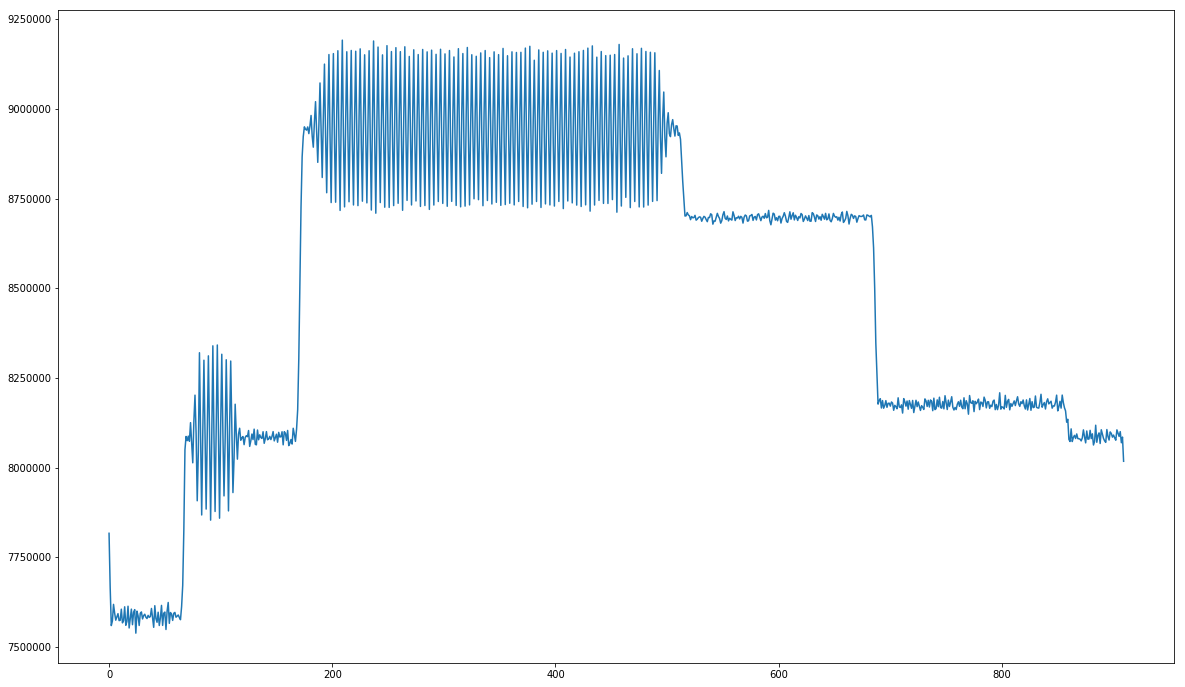

In [13]:
f1 = copy.deepcopy(fields[1])

l = 18

ds1p = f1.downscale(lineinfo=f1.linelocs2, final = False)
plt.plot(ds1p[0][910*l:(910*l)+910])

print(np.std(ds1p[0][(910*l)+75:(910*l)+118]))

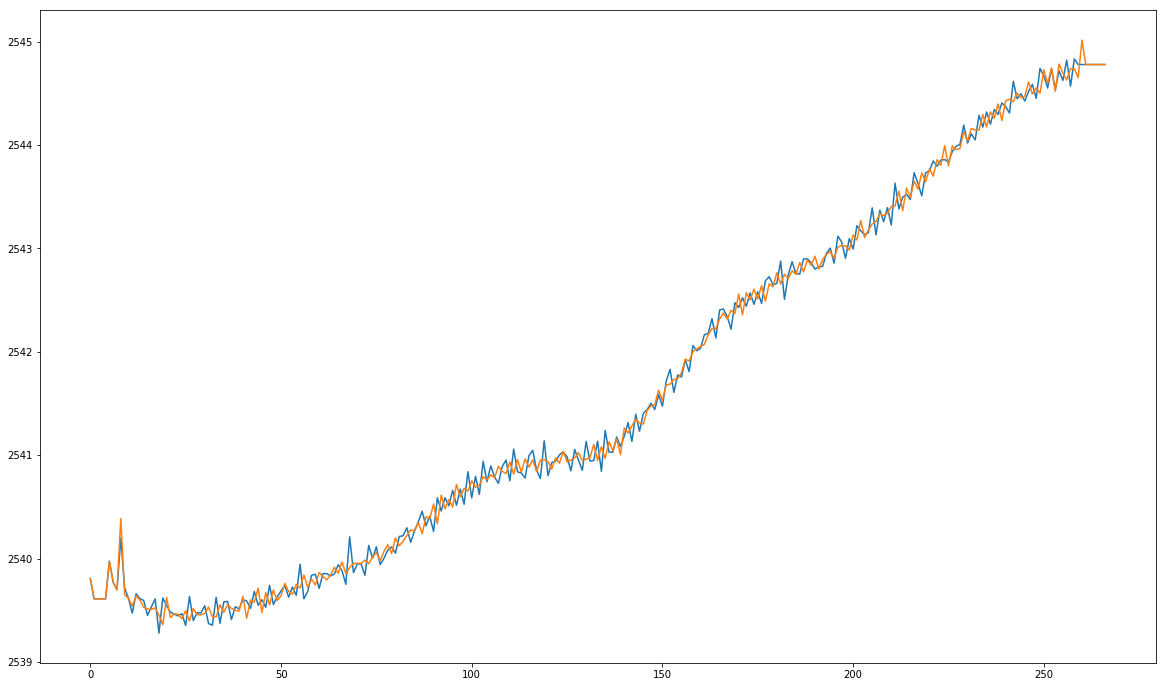

In [6]:
f1 = fields[9]
#plt.plot(np.diff(f1.linelocs1))
plt.plot(np.diff(f1.linelocs2))
plt.plot(np.diff(f1.linelocs3))

(239330,)
uint8 (263, 910) (263, 910)


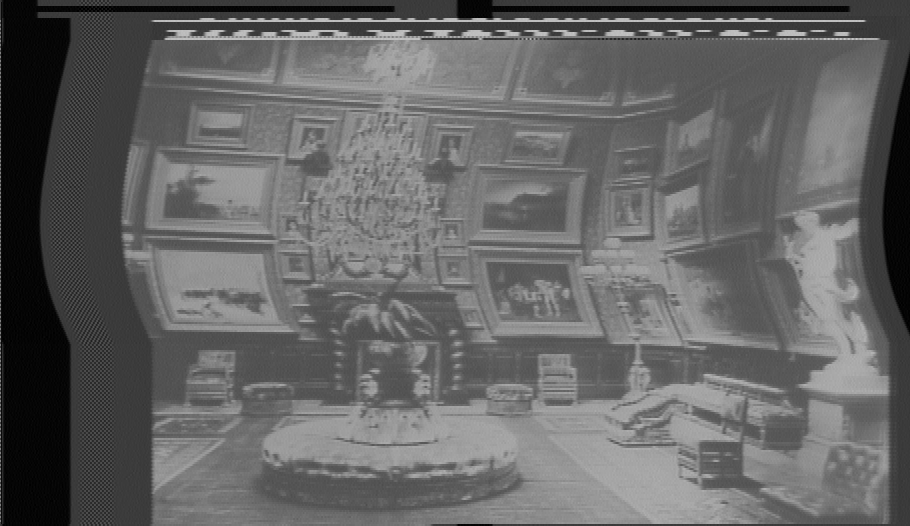

In [54]:
f = fields[9]
draw_raw_bwimage(f.dspicture, 910, 263)

In [56]:
f = copy.deepcopy(fields[9])

(239330,)
uint8 (263, 910) (263, 910)


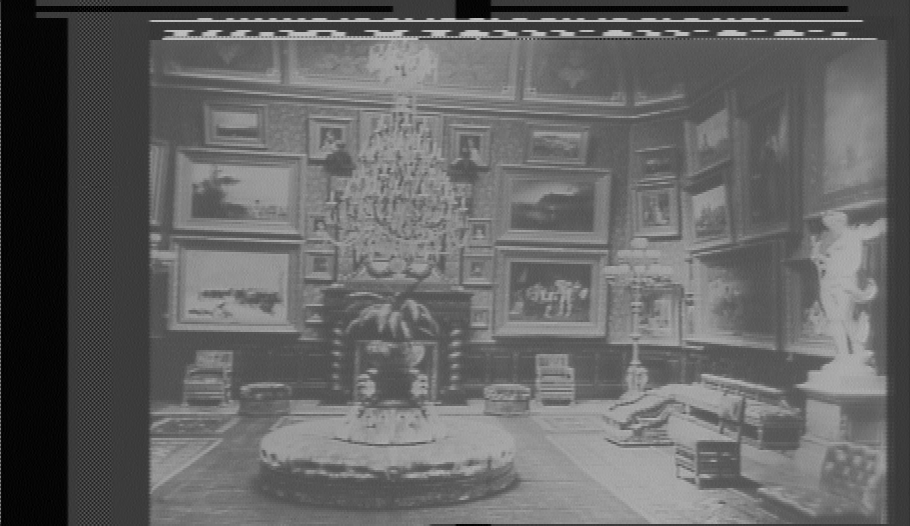

In [61]:
pic = f.downscale(lineinfo=f.linelocs2, final=True)[0]
draw_raw_bwimage(pic, 910, 263)

27848.12530211135


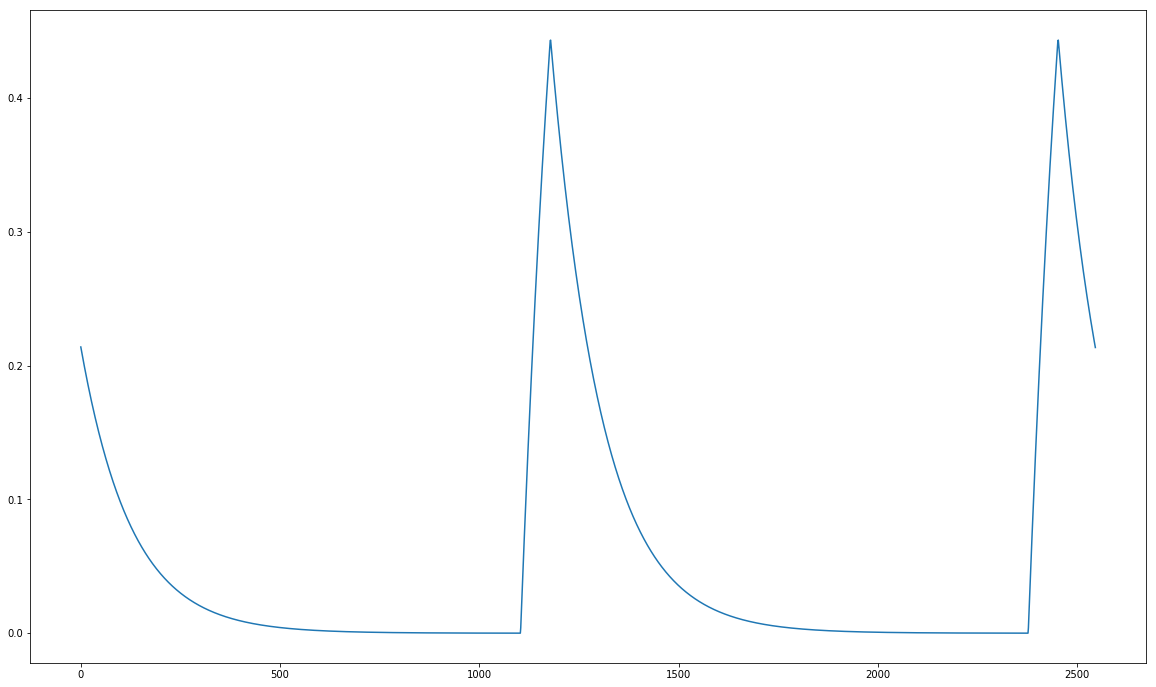

In [176]:
#f = fields[3]
l = 0
f1 = copy.deepcopy(fields[0])
print(f1.linelocs2[l])
#plt.plot(f1.data[0]['demod_05'][int(f1.linelocs2[l]+0):int(f1.linelocs2[l+1])])
(f1.data[0]['demod_sync'][int(f1.linelocs1[l]+0):int(f1.linelocs2[l+1])])
plt.plot(f1.data[0]['demod_sync'][int(f1.linelocs1[l]+0):int(f1.linelocs1[l+1])])
#plt.plot(f3.data[0]['demod_05'][int(f3.linelocs2[l]+0):int(f3.linelocs2[l+1])])